<a href="https://colab.research.google.com/github/BPavanVenkataSai/Image-Denoising-using-CNN/blob/main/Image_Denoising_6_2_T4_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.losses import MeanSquaredError
from keras.layers import Conv2D, Activation, ELU, BatchNormalization, Dropout, MaxPooling2D, Conv2DTranspose, Input, Add, concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.metrics import MeanAbsoluteError
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import math
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [5]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [6]:
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [7]:
clean_images_dir = "/content/actual_images"

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img

# Function to add salt and pepper noise to an image
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = image.copy()
    num_salt = np.ceil(salt_prob * image.size * 3).astype(int)  # Multiplied by 3 for RGB
    num_pepper = np.ceil(pepper_prob * image.size * 3).astype(int)  # Multiplied by 3 for RGB

    # Add salt noise
    coords = [np.random.randint(0, i, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 1  # White pixels

    # Add pepper noise
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0  # Black pixels

    return noisy_image

# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Function to apply geometric transformations
def apply_geometric_transformations(img):
    img = img.reshape((1,) + img.shape)  # Reshape for the generator
    aug_iter = datagen.flow(img, batch_size=1)
    return aug_iter[0].reshape(img.shape[1:])

# Load Clean Images
clean_images = []
for filename in os.listdir(clean_images_dir):
    img_path = os.path.join(clean_images_dir, filename)
    img = load_and_preprocess_image(img_path)
    clean_images.append((filename, img))

# Add geometric transformations to clean images and append to clean images
augmented_clean_images = []
for filename, img in clean_images:
    for i in range(25):  # Create 10 augmented images for each original image
        transformed_img = apply_geometric_transformations(img)
        augmented_clean_images.append((filename + f'_aug_{i}', transformed_img))

clean_images += augmented_clean_images

# Add noise to clean images to create noisy images
salt_prob = 0.01  # 1% salt noise
pepper_prob = 0.01  # 1% pepper noise
noisy_images = [(filename, add_salt_and_pepper_noise(img, salt_prob, pepper_prob)) for filename, img in clean_images]

# Sort and match images based on filenames
noisy_images.sort(key=lambda x: x[0])
clean_images.sort(key=lambda x: x[0])

# Separate filenames and images
noisy_images = np.array([img for _, img in noisy_images])
clean_images = np.array([img for _, img in clean_images])

# Display the shapes of noisy and clean images
print("Noisy Images Shape:", noisy_images.shape)
print("Clean Images Shape:", clean_images.shape)

Noisy Images Shape: (7800, 128, 128, 3)
Clean Images Shape: (7800, 128, 128, 3)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio

# Calculate PSNR for each pair of images
psnr_values = []
for noisy_img, clean_img in zip(noisy_images, clean_images):
    psnr = peak_signal_noise_ratio(clean_img, noisy_img, data_range=clean_img.max() - clean_img.min())
    psnr_values.append(psnr)

# Mean PSNR across all images
mean_psnr = np.mean(psnr_values)
print(mean_psnr)

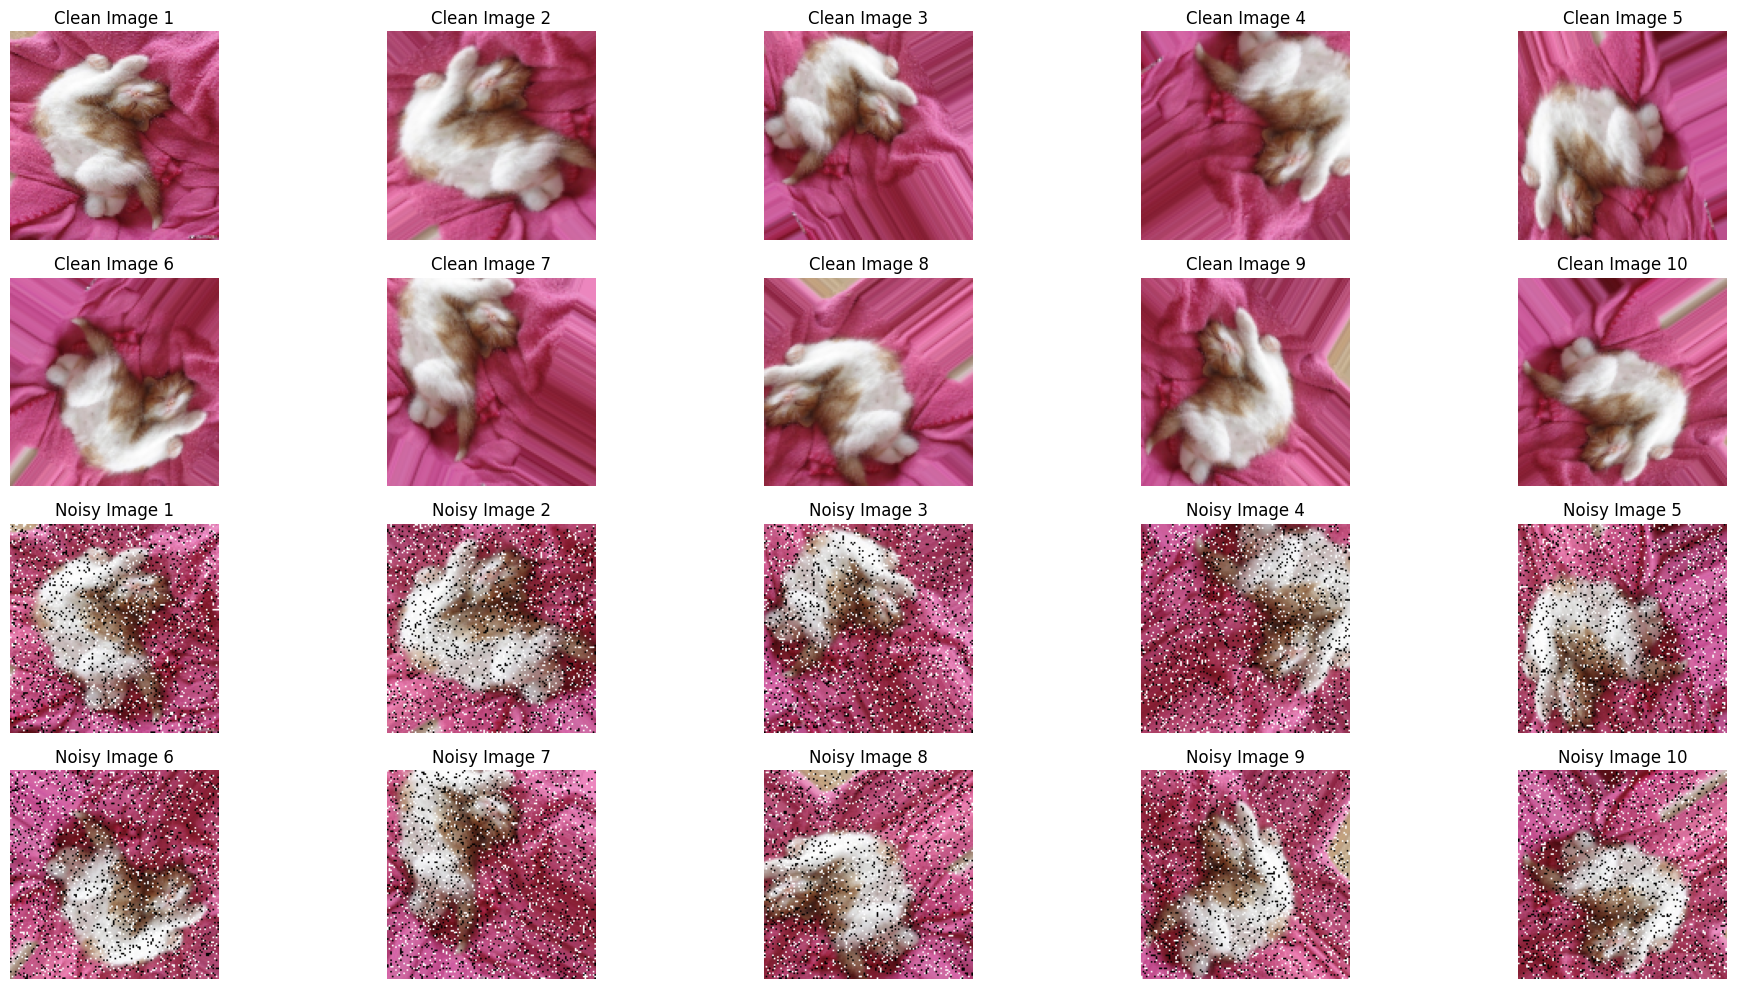

In [ ]:
# Display some example images
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(4, 5, i + 1)
    plt.title(f"Clean Image {i+1}")
    plt.imshow(clean_images[i])
    plt.axis('off')

    plt.subplot(4, 5, i + 11)
    plt.title(f"Noisy Image {i+1}")
    plt.imshow(noisy_images[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
def create_denoising_model():
    input_img = Input(shape=(128, 128, 3))

    # First convolutional layer with ReLU activation
    x = Conv2D(128, (3, 3), padding='same')(input_img)
    x = Activation('relu')(x)

    # Second convolutional layer with ReLU activation
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # Third convolutional layer with ReLU activation
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # Fourth convolutional layer with ReLU activation
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # Fifth convolutional layer with ReLU activation
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # Sixth convolutional layer with ReLU activation
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    # Output convolutional layer
    output_img = Conv2D(3, (3, 3), padding='same')(x)

    model = Model(inputs=input_img, outputs=output_img)
    return model

# Create the denoising model
model = create_denoising_model()

# Display the model summary
model.summary()

# Define the optimizer with an initial learning rate
optimizer = Adam(learning_rate=0.001)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with loss and metrics
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['accuracy', MeanAbsoluteError(), psnr_metric, ssim_metric])

# Assume noisy_images and clean_images are your training datasets
# Train the model
history = model.fit(noisy_images, clean_images, epochs=50, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 activation (Activation)     (None, 128, 128, 128)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 activation_1 (Activation)   (None, 128, 128, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 activation_2 (Activation)   (None, 128, 128, 64)      0     

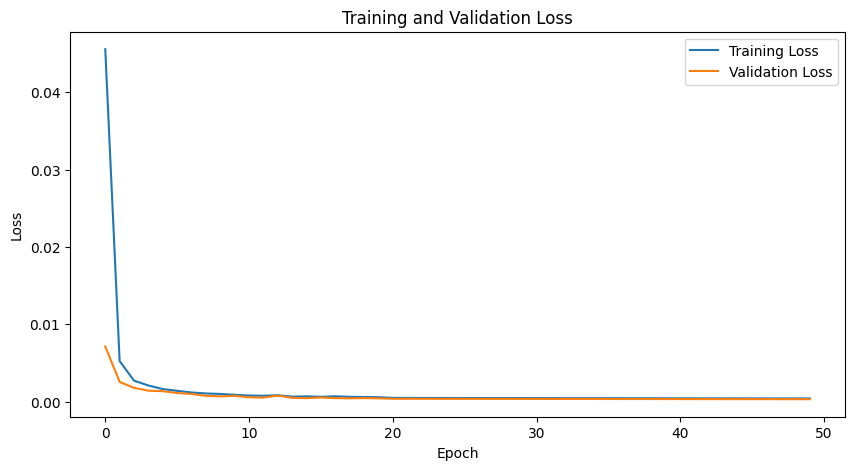

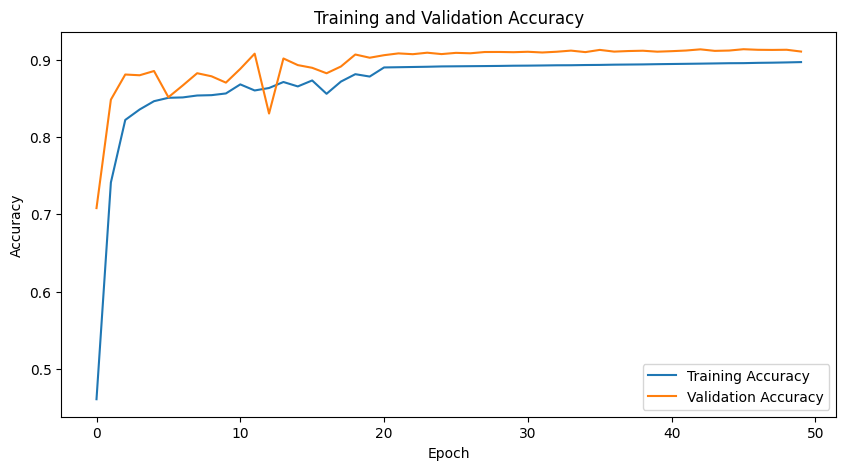

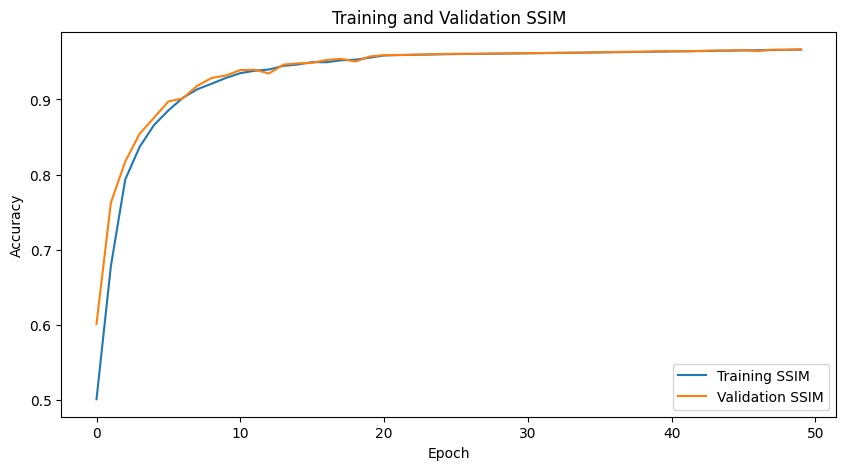

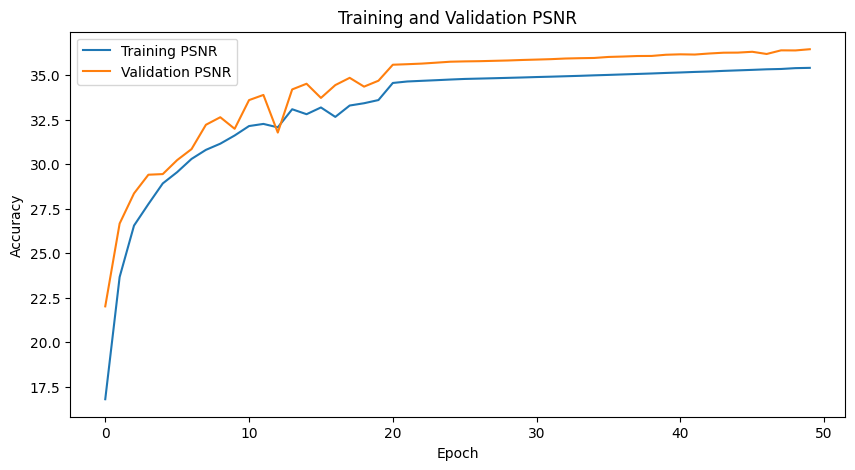

In [11]:
import matplotlib.pyplot as plt
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Plot training ssim and validation ssim
plt.figure(figsize=(10, 5))
plt.plot(history.history['ssim_metric'], label='Training SSIM')
plt.plot(history.history['val_ssim_metric'], label='Validation SSIM')
plt.title('Training and Validation SSIM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training PSNR and validation PSNR
plt.figure(figsize=(10, 5))
plt.plot(history.history['psnr_metric'], label='Training PSNR')
plt.plot(history.history['val_psnr_metric'], label='Validation PSNR')
plt.title('Training and Validation PSNR')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
model.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


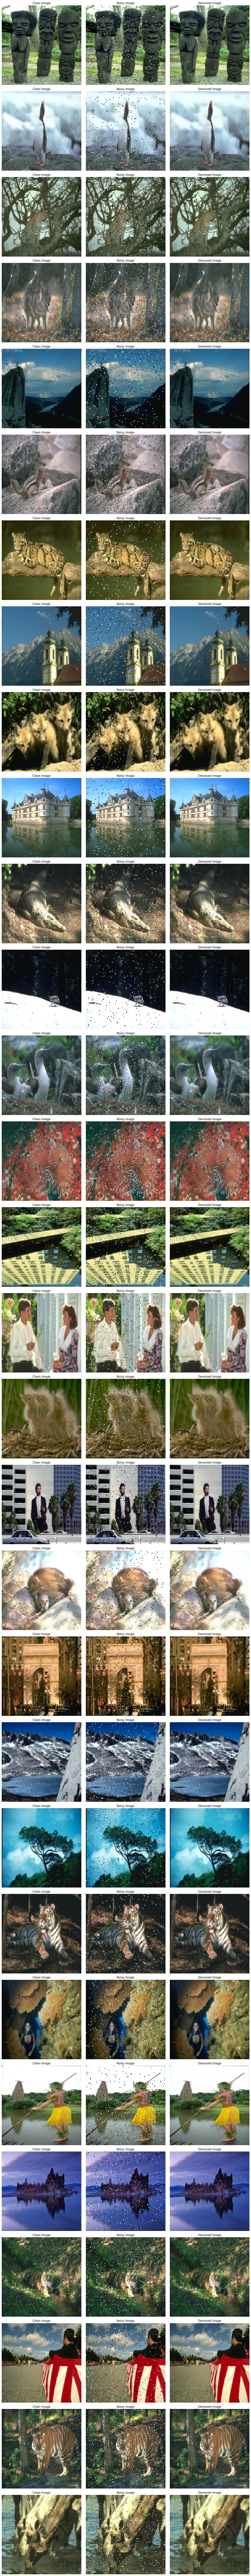

In [15]:
# Load the model with custom objects
model = tf.keras.models.load_model('/content/model1.h5', custom_objects={'psnr_metric': psnr_metric, 'ssim_metric': ssim_metric})

def add_salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy = image.copy()
    num_salt = np.ceil(salt_prob * image.size * 0.5)
    num_pepper = np.ceil(pepper_prob * image.size * 0.5)

    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 1

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 0

    return noisy

def process_image(model, image_path, target_size=(128, 128)):
    # Load the original image and resize it
    original_image = Image.open(image_path)
    original_size = original_image.size
    resized_image = original_image.resize(target_size)

    # Convert image to numpy array and normalize
    clean_image = np.array(resized_image) / 255.0

    # Add noise to the original image
    noisy_image = add_salt_and_pepper_noise(clean_image, salt_prob=0.01, pepper_prob=0.01)

    # Predict the denoised image using the model
    denoised_image = model.predict(np.expand_dims(noisy_image, axis=0)).squeeze()

    return clean_image, noisy_image, denoised_image

# Load and denoise multiple test images
test_image_dir = '/content/test_images'
test_image_paths = [os.path.join(test_image_dir, filename) for filename in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, filename))]
processed_images = [process_image(model, image_path) for image_path in test_image_paths]

# Display the processed images
num_images = len(processed_images)
fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))

for i, (clean, noisy, denoised) in enumerate(processed_images):
    axes[i, 0].imshow(clean)
    axes[i, 0].set_title('Clean Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy)
    axes[i, 1].set_title('Noisy Image')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(denoised)
    axes[i, 2].set_title('Denoised Image')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [16]:
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsoluteError

# Define your optimizer
optimizer = tf.keras.optimizers.Adam()

# Load the model with custom objects
model = tf.keras.models.load_model('/content/model1.h5', custom_objects={'psnr_metric': psnr_metric,'ssim_metric': ssim_metric})

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with loss and metrics
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['accuracy', MeanAbsoluteError(), psnr_metric, ssim_metric])

# Assume noisy_images and clean_images are your training datasets
# Train the model
history = model.fit(noisy_images, clean_images, epochs=10, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])

Epoch 1/10
98/98 [==============================] - 51s 483ms/step - loss: 0.0054 - accuracy: 0.6982 - mean_absolute_error: 0.0440 - psnr_metric: 26.0423 - ssim_metric: 0.8158 - val_loss: 8.6666e-04 - val_accuracy: 0.8675 - val_mean_absolute_error: 0.0190 - val_psnr_metric: 31.4137 - val_ssim_metric: 0.8960 - lr: 0.0010
Epoch 2/10
98/98 [==============================] - 45s 457ms/step - loss: 8.4147e-04 - accuracy: 0.8491 - mean_absolute_error: 0.0182 - psnr_metric: 31.6493 - ssim_metric: 0.9223 - val_loss: 5.6875e-04 - val_accuracy: 0.8765 - val_mean_absolute_error: 0.0146 - val_psnr_metric: 33.3295 - val_ssim_metric: 0.9325 - lr: 0.0010
Epoch 3/10
98/98 [==============================] - 48s 486ms/step - loss: 6.8054e-04 - accuracy: 0.8537 - mean_absolute_error: 0.0163 - psnr_metric: 32.6028 - ssim_metric: 0.9405 - val_loss: 6.2417e-04 - val_accuracy: 0.8796 - val_mean_absolute_error: 0.0169 - val_psnr_metric: 32.6567 - val_ssim_metric: 0.9462 - lr: 0.0010
Epoch 4/10
98/98 [========